In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test

In [2]:
# Breast Cancer Data 
df = pd.read_excel("C:/Users/DrHeh/Google Drive/From Dropbox/samples/roc/20200513_ most predictable variables_looking for bast cutoffs.xlsx")
df_clean = df.iloc[:-6].drop(columns="IRB").replace({"Outcome":{"Poor":0, "Good":1}})


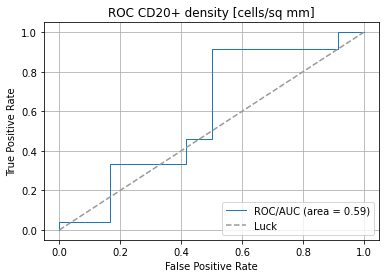

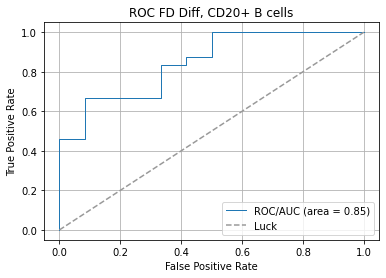

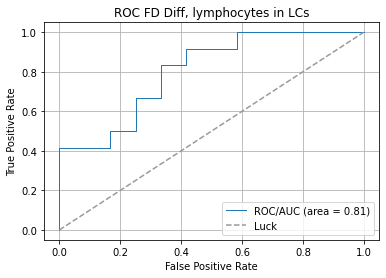

,Vars,Data_cutoff,ROC_AUC
0,CD20+ density [cells/sq mm],35.200,0.593750
1,"FD Diff, CD20+ B cells",0.640,0.847222
2,"FD Diff, lymphocytes in LCs",0.141,0.805556


In [39]:
#Use ROC find best cutoffs

# Using LogisticRegression fitting, compute fpr, tpr at a number of cutoffs
Results ={"Vars":[],"Data_cutoff":[], "ROC_AUC":[]}
for i in np.arange(3, len(df_clean.columns)):
    predictors = df_clean.iloc[:,i].values.reshape(-1,1)
    #predictors = df_clean.iloc[:,np.r_[3:len(df_clean.columns)]].values
    label = df_clean.iloc[:,1].values.astype(int)
    
    model = LogisticRegression()
    model.fit(predictors, label)
    probs = model.predict_proba(predictors)
    
    fpr, tpr, thresholds = roc_curve(label, probs[:,1]) 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC/AUC (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC %s'% df_clean.columns[i])
    plt.legend(loc="lower right")
    plt.savefig("rocauc.pdf", format="pdf")
    plt.show()
    
    optimal_thresholds = thresholds[np.argmax(tpr-fpr)]  
    data = pd.DataFrame({"%s" %df_clean.columns[i]:df_clean.iloc[:,i].values, 
                        "Labels":label, "Probs":probs[:,1]}).sort_values(by=["Probs"])
    cutoff = data.loc[data[data.columns[2]] == optimal_thresholds][[data.columns[0]]].iloc[0,0]
    
    Results["Vars"].append(df_clean.columns[i])
    Results["Data_cutoff"].append(cutoff)
    Results["ROC_AUC"].append(roc_auc)

    
Res = pd.DataFrame(Results)
Res

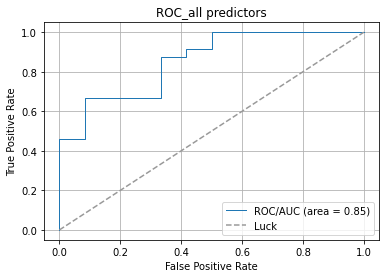

In [8]:
#Using all predictors 

predictors = df_clean.iloc[:,np.r_[3:len(df_clean.columns)]].values
label = df_clean.iloc[:,1].values.astype(int)
    
model = LogisticRegression()
model.fit(predictors, label)
probs = model.predict_proba(predictors)
    
fpr, tpr, thresholds = roc_curve(label, probs[:,1]) 
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC/AUC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_all predictors')
plt.legend(loc="lower right")
plt.savefig("rocauc.pdf", format="pdf")
plt.show()

In [56]:
#Convert regression to categorical based on above findings

Log_p ={"Vars":[],"Log-p":[]}
for i in np.arange(3, len(df_clean.columns)):
    g1=df_clean[(df_clean.iloc[:,i]>=Res["Data_cutoff"][i-3])]
    g2=df_clean[(df_clean.iloc[:,i]<Res["Data_cutoff"][i-3])]
    g1["Class%s"%df_clean.columns[i]]=1
    g2["Class%s"%df_clean.columns[i]]=0
    lr = logrank_test(g1["Class%s"%df_clean.columns[i]], g2["Class%s"%df_clean.columns[i]], g1.Outcome, g2.Outcome)

    Log_p["Vars"].append(df_clean.columns[i])
    Log_p["Log-p"].append(lr.p_value)
    
Log=pd.DataFrame(Log_p)
Log

<ipython-input-56-5115af01d74f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df_clean.columns[i]]=1
<ipython-input-56-5115af01d74f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df_clean.columns[i]]=0


,Vars,Log-p
0,CD20+ density [cells/sq mm],0.007267
1,"FD Diff, CD20+ B cells",0.002779
2,"FD Diff, lymphocytes in LCs",0.003096


In [62]:
#Final
Res_all=pd.merge(Res,Log,on="Vars")
Res_all

,Vars,Data_cutoff,ROC_AUC,Log-p
0,CD20+ density [cells/sq mm],35.200,0.593750,0.007267
1,"FD Diff, CD20+ B cells",0.640,0.847222,0.002779
2,"FD Diff, lymphocytes in LCs",0.141,0.805556,0.003096
